# Main SS analysis development



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from processor.SS_analysis import *
from Tools.config_helpers import *
from klepto.archives import dir_archive

In [3]:
from processor.std_acumulators import desired_output, add_processes_to_output

In [4]:
# the equivalent code can be run with ipython -i SS_analysis.py within the processor directory

from Tools.samples import fileset_2018, fileset_2018_small
from processor.std_acumulators import desired_output, add_processes_to_output

overwrite = False

# load the config and the cache
cfg = loadConfig()

cacheName = 'SS_analysis'
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cacheName), serialized=True)
histograms = sorted(list(desired_output.keys()))

year = 2018



fileset = {
    #'inclusive': glob.glob('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/inclusive_1000.root'),
    #'plus': glob.glob('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/plus_2000.root'),
    #'topW_v2': fileset_2018['topW_v2'], # verified that v2 and v3 are similar, v3 has more stats!
    'topW_v3': fileset_2018['topW_v3'],
    'topW_EFT_cp8': fileset_2018['topW_EFT_cp8'],
    'topW_EFT_mix': fileset_2018['topW_EFT_mix'],
    #'TTW': fileset_2018['TTW'],
    #'TTZ': fileset_2018['TTZ'],
    #'TTH': fileset_2018['TTH'],
    #'ttbar': fileset_2018['ttbar'][:12],
    #'ttbar1l': fileset_2018['ttbar1l'][:5],
    #'ttbar2l': fileset_2018['ttbar2l'][:5],
}


add_processes_to_output(fileset, desired_output)


exe_args = {
    'workers': 16,
    'function_args': {'flatten': False},
    "schema": NanoAODSchema,
}
exe = processor.futures_executor

if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    print ("I'm running now")
    
    output = processor.run_uproot_job(
        fileset,
        "Events",
        SS_analysis(year=year, variations=variations, accumulator=desired_output),
        exe,
        exe_args,
        chunksize=250000,
    )
    
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()




In [29]:
def getChannel(histogram, n_ele=0):
    '''
    gets you just the ee/emu/mumu channel of each histogram by requiring 0-2 electrons
    '''
    bins_n_ele  = hist.Bin('n_ele', r'$N_{e}$', 1, n_ele-0.5, n_ele+0.5)
    tmp = histogram.copy()
    tmp = tmp.rebin('n_ele', bins_n_ele)
    tmp = tmp.sum('n_ele')
    #tmp = tmp.copy().project("dataset",axis)
    #nEvents = tmp.sum("dataset").values(overflow='over')[()].sum()
    #print ("Total number of events for signal point: %s"%nEvents)
    return tmp

In [41]:
getChannel(output['chargeFlip_vs_nonprompt'], n_ele=1).values()

{('ttbar2l',): array([[0.54289828, 1.32560503, 0.08074167, 0.        ],
        [1.7934777 , 0.29214419, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 ('ttbar1l',): array([[ 0.91038302, 14.85033475,  0.        ,  0.        ],
        [ 0.        ,  1.76290029,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]])}

In [37]:
output['chargeFlip_vs_nonprompt'].sum('n_ele').values()

{('ttbar2l',): array([[0.66461717, 2.84140666, 0.08074167, 0.        ],
        [2.92356645, 0.44128586, 0.        , 0.        ],
        [0.        , 0.07532913, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]]),
 ('ttbar1l',): array([[ 2.38471042, 30.44452793,  0.        ,  0.        ],
        [ 0.        ,  1.95539681,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]])}

Text(0, 0.5, '$N_{nonprompt}$')

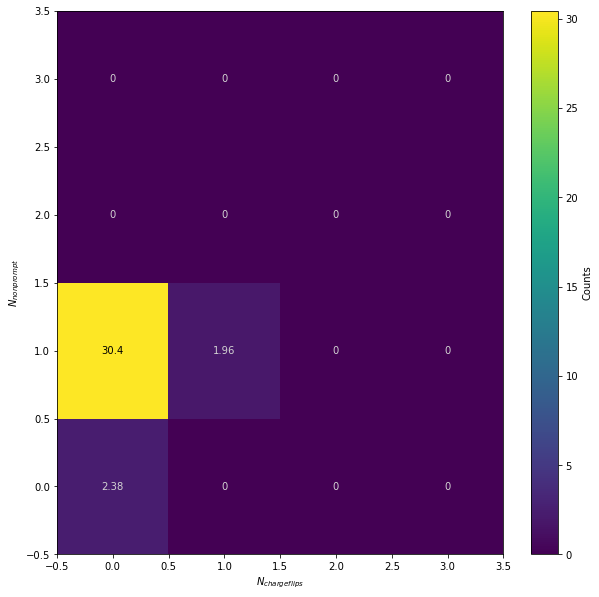

In [47]:
import matplotlib.pyplot as plt

fig, ax  = plt.subplots(1,1,figsize=(10,10) )
ax = hist.plot2d(
    output['chargeFlip_vs_nonprompt']['ttbar1l'].sum('n_ele').sum('dataset'),
    xaxis='n1',
    ax=ax,
    text_opts={'format': '%.3g'},
    patch_opts={},
)
ax.set_xlabel(r'$N_{charge flips}$')
ax.set_ylabel(r'$N_{nonprompt}$')

Text(0, 0.5, '$N_{nonprompt}$')

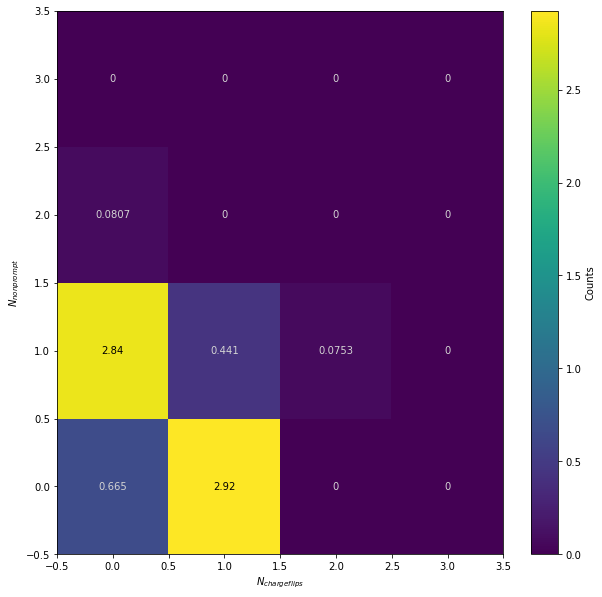

In [48]:
fig, ax  = plt.subplots(1,1,figsize=(10,10) )
ax = hist.plot2d(
    output['chargeFlip_vs_nonprompt']['ttbar2l'].sum('n_ele').sum('dataset'),
    xaxis='n1',
    ax=ax,
    text_opts={'format': '%.3g'},
    patch_opts={},
)
ax.set_xlabel(r'$N_{charge flips}$')
ax.set_ylabel(r'$N_{nonprompt}$')

In [29]:
from Tools.helpers import getCutFlowTable

processes = [
    #"inclusive", "plus",
    #'topW_v2',
    'topW_v3',
    'topW_EFT_cp8', 'topW_EFT_mix',
    #'TTW', 'TTZ', 'TTH', 'ttbar',
]
lines = ['entry']
lines += ['lepveto', 'dilep', 'SS', 'filter', 'p_T(lep0)>25', 'p_T(lep1)>20', ]
lines += ['N_jet>3', 'N_central>2', 'N_btag>0', 'N_fwd>0', 'N_jet>4', 'N_central>3', 'ST', 'MET>50', 'delta_eta', 'fwd_p>500', 'p_T(lep0)>40', 'p_T(lep1)>30']
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df


,topW_v3,topW_EFT_cp8,topW_EFT_mix,S/B
entry,226.4 +/- 0.2,3000.0 +/- 7.0,2449.0 +/- 6.0,0.0415
lepveto,119.7 +/- 0.2,694.3 +/- 3.3,560.1 +/- 3.0,0.0954
dilep,45.77 +/- 0.11,242.2 +/- 1.9,192.0 +/- 1.8,0.1054
SS,34.68 +/- 0.09,80.88 +/- 1.11,62.76 +/- 1.02,0.2414
filter,34.64 +/- 0.09,80.78 +/- 1.11,62.66 +/- 1.01,0.2415
p_T(lep0)>25,34.24 +/- 0.09,80.19 +/- 1.11,62.25 +/- 1.01,0.2404
p_T(lep1)>20,31.34 +/- 0.09,74.38 +/- 1.07,57.53 +/- 0.97,0.2376
N_jet>3,28.06 +/- 0.08,67.3 +/- 1.01,49.91 +/- 0.89,0.2394
N_central>2,27.29 +/- 0.08,65.65 +/- 1.0,48.84 +/- 0.88,0.2384
N_btag>0,24.79 +/- 0.08,59.6 +/- 0.95,44.29 +/- 0.84,0.2386


In [11]:
ak.sum(test, axis=1)

<Array [6, 9, 0, 6] type='4 * int64'>

In [59]:
fileset_2018['topW_v3']

['/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_1.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_2.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWminusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_3.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_1.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_2.root',
 '/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.2.3/ProjectMetis_TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoSkim_3.root']

In [30]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,topW_EFT_cp8,topW_EFT_mix
entry,1.0000,1.0000,1.0000
lepveto,0.5287,0.2315,0.2287
dilep,0.3824,0.3488,0.3427
SS,0.7578,0.3340,0.3269
filter,0.9990,0.9987,0.9984
p_T(lep0)>25,0.9883,0.9927,0.9934
p_T(lep1)>20,0.9153,0.9276,0.9242
N_jet>3,0.8954,0.9048,0.8675
N_central>2,0.9727,0.9755,0.9786
N_btag>0,0.9083,0.9079,0.9070


In [84]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import *
import re

bkgonly = re.compile('(?!(MuonEG))')

N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)
N_bins_red = hist.Bin('multiplicity', r'$N$', 5, -0.5, 4.5)
pt_bins = hist.Bin('pt', r'$p_{T}\ (GeV)$', 30, 0, 300)
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', 10, 0, 300)
eta_bins = hist.Bin('eta', r'$\eta $', 25, -5.0, 5.0)

Data: 0 MC: 62.79
Data: 0 MC: 62.79


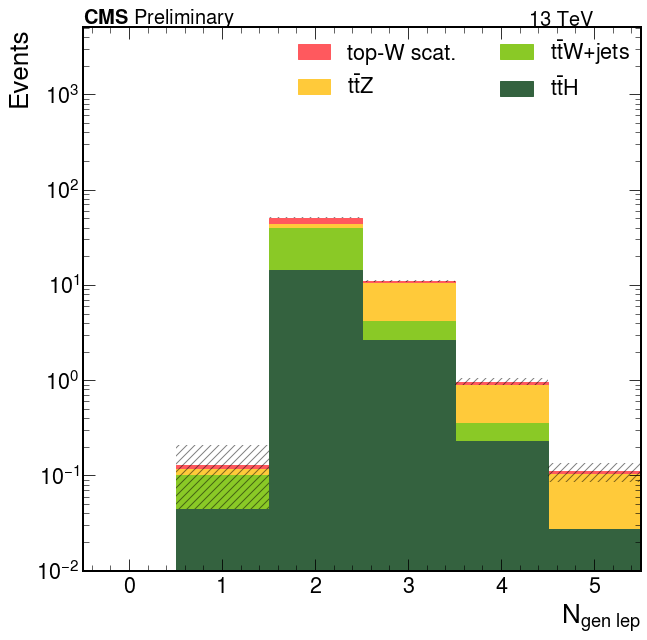

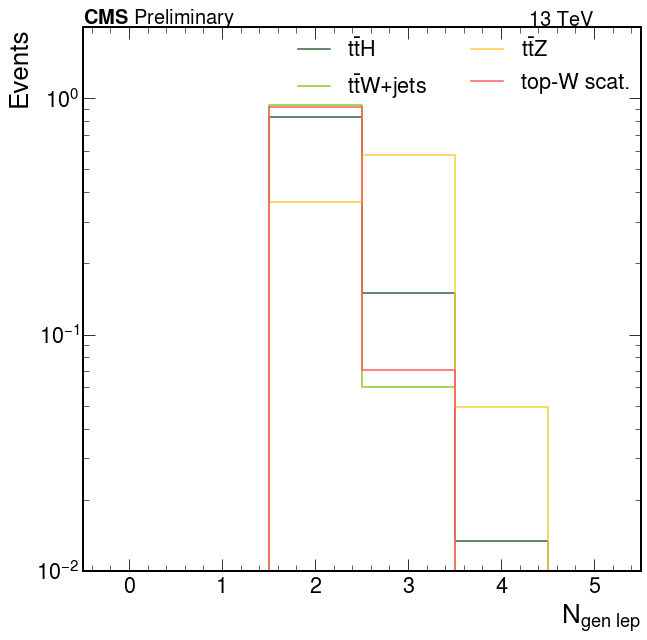

In [60]:
makePlot(output, 'nGenL', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ lep}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nGenL', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ lep}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


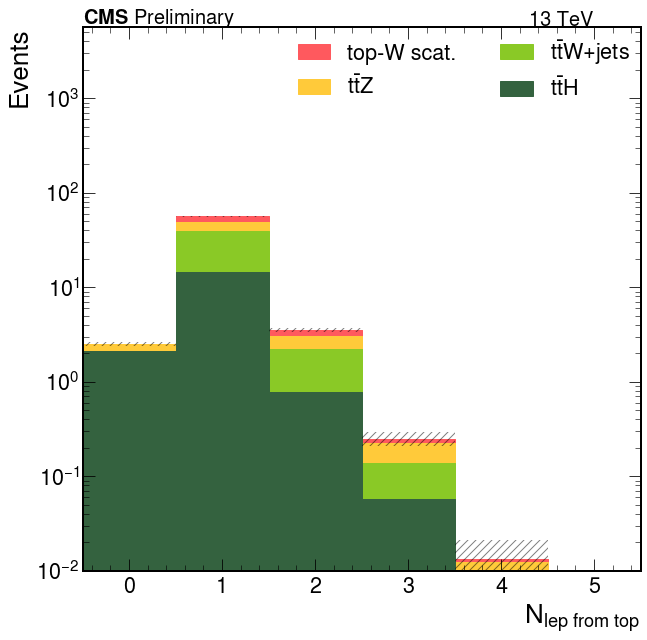

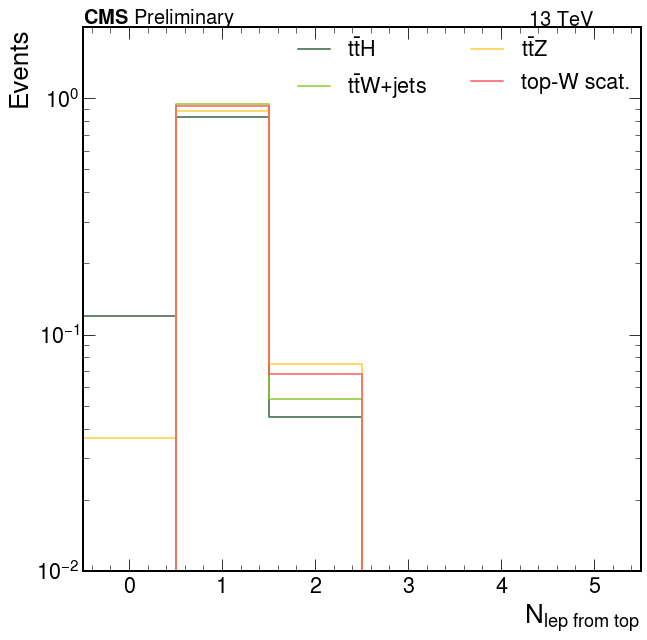

In [39]:
makePlot(output, 'nLepFromTop', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ top}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromTop', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ top}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


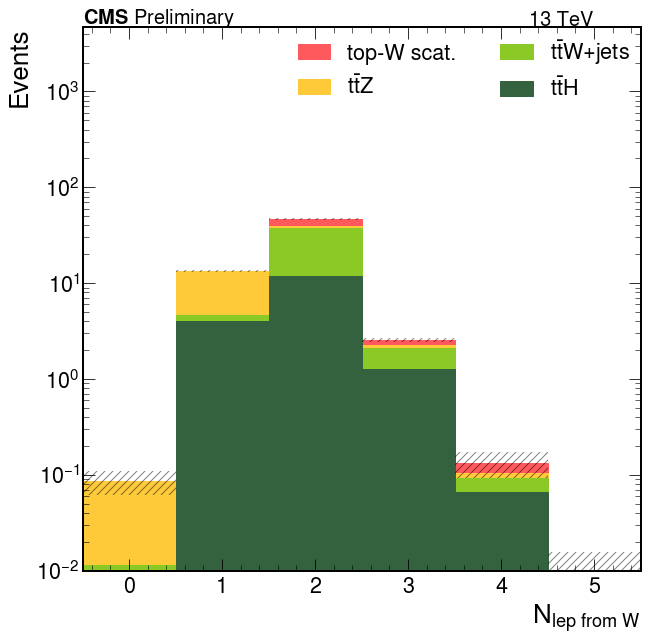

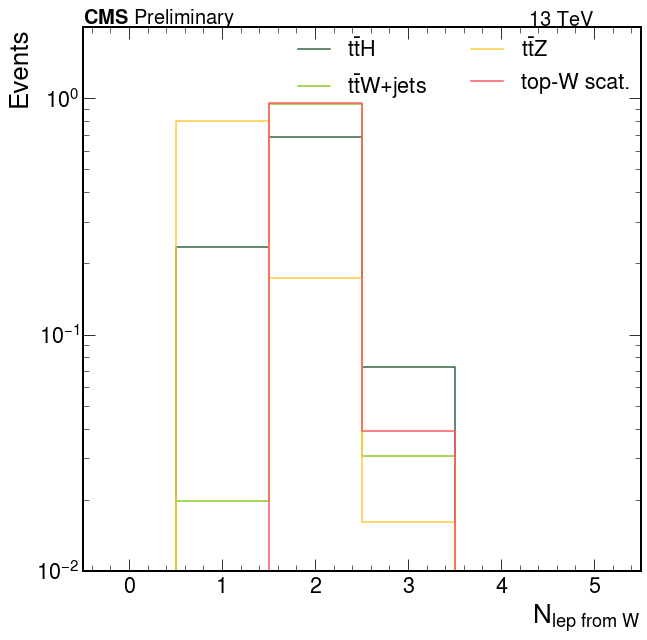

In [40]:
makePlot(output, 'nLepFromW', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ W}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromW', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ W}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


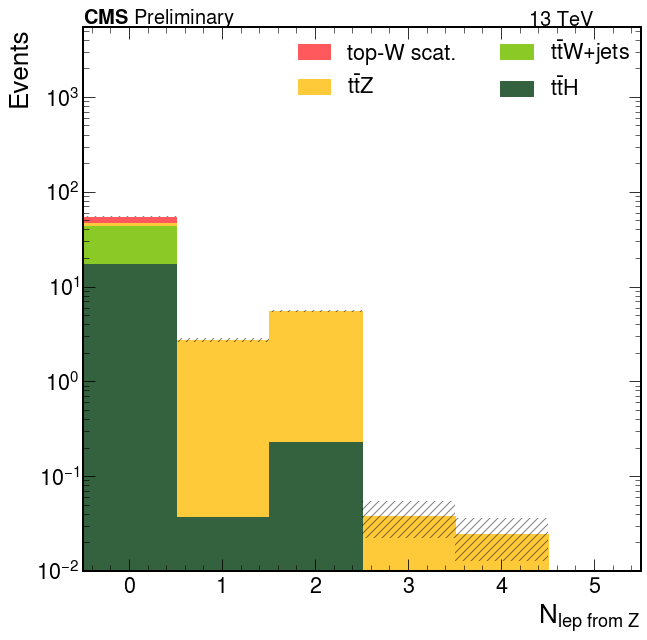

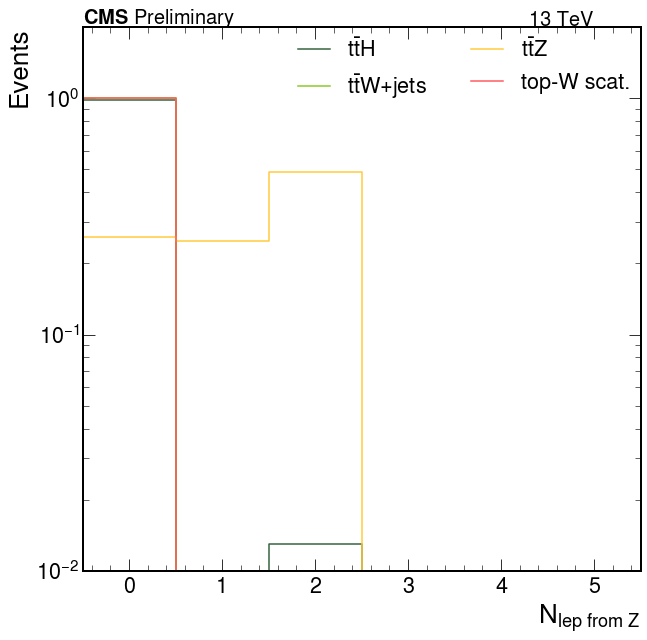

In [41]:
makePlot(output, 'nLepFromZ', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ Z}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromZ', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ Z}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


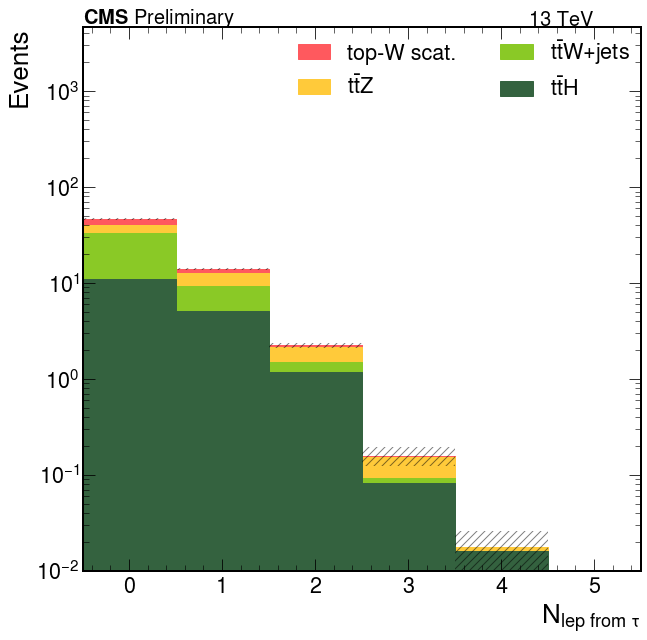

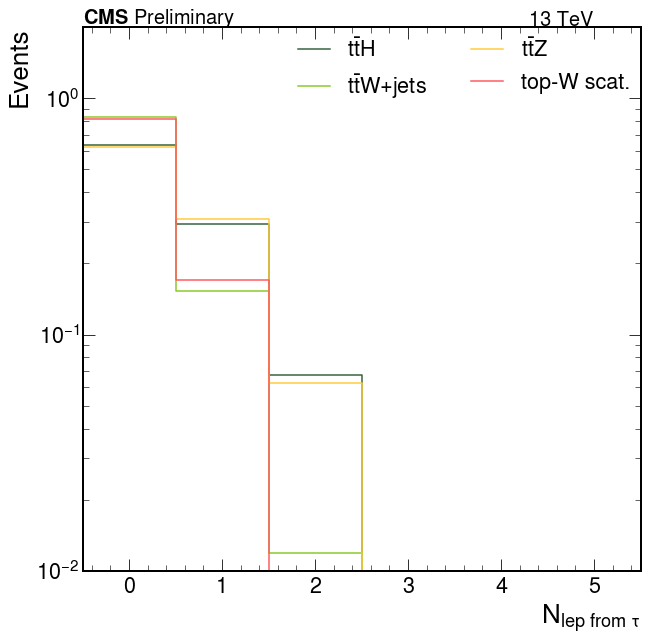

In [43]:
makePlot(output, 'nLepFromTau', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nLepFromTau', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{lep\ from\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


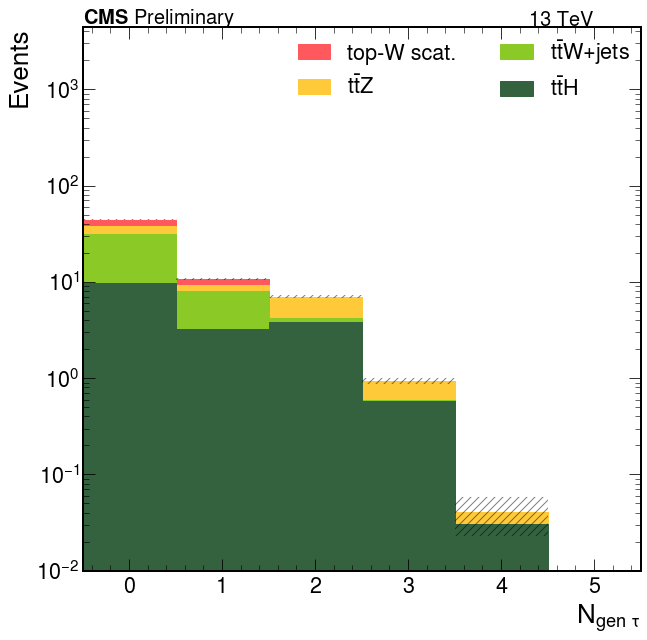

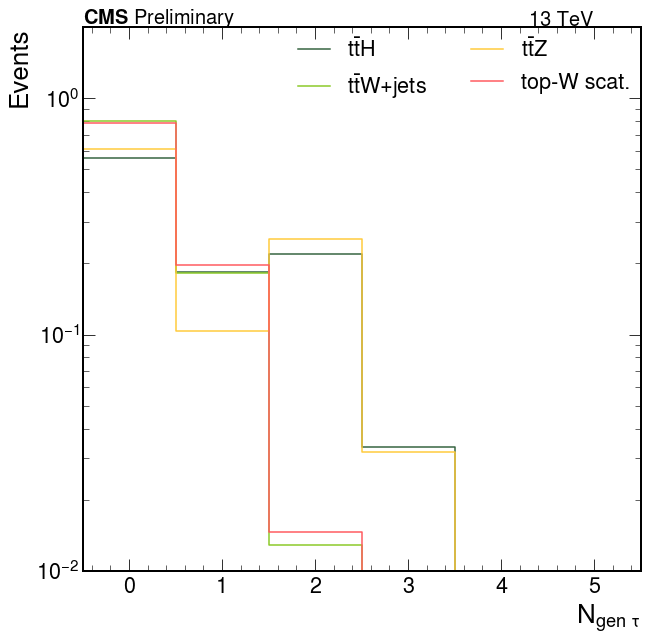

In [44]:
makePlot(output, 'nGenTau', 'multiplicity',
         data_sel=None,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'nGenTau', 'multiplicity',
         data_sel=None,
         shape=True,
         bins=N_bins_red, log=True, normalize=False, axis_label=r'$N_{gen\ \tau}$',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


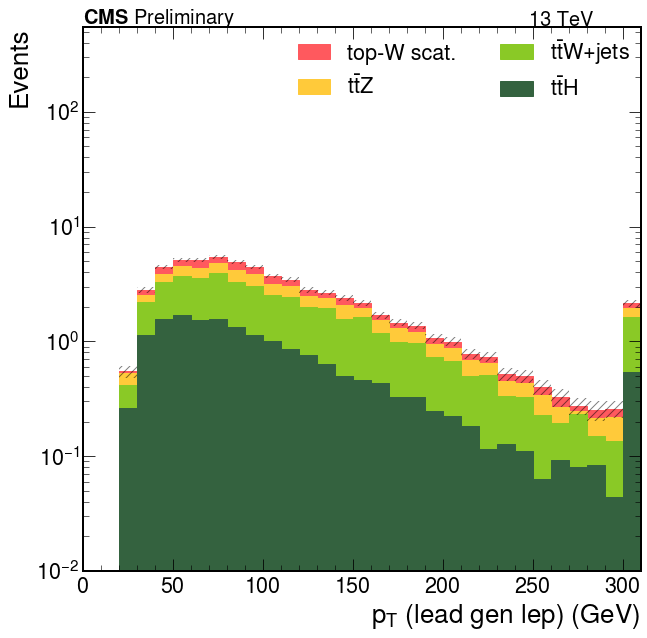

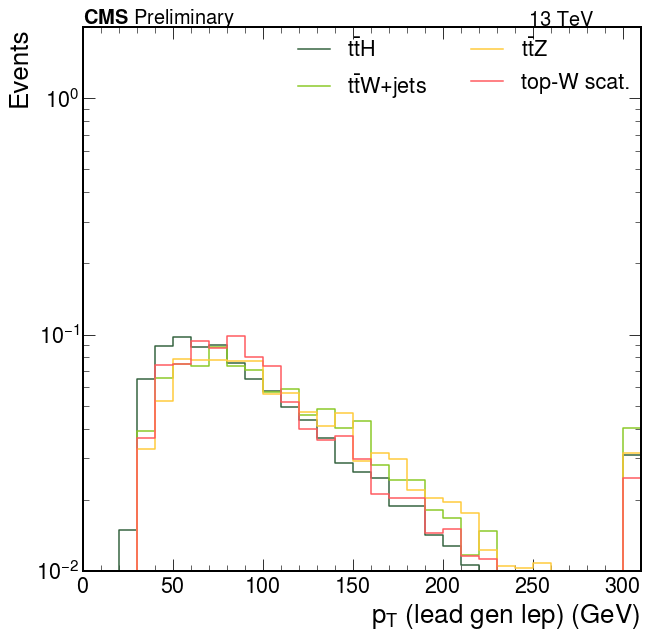

In [68]:
makePlot(output, 'lead_gen_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'lead_gen_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 46.99
Data: 0 MC: 46.99


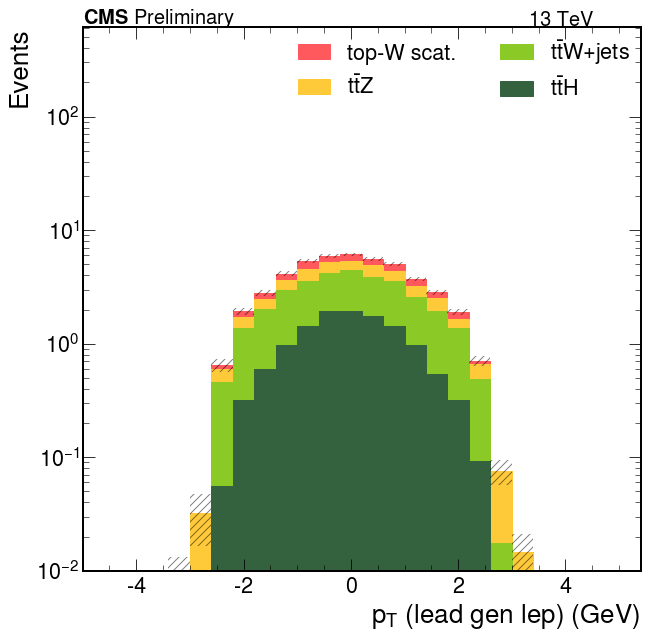

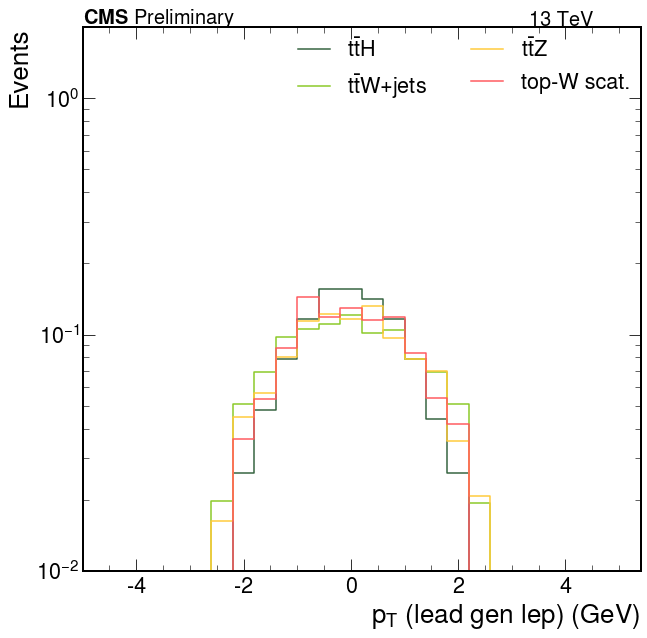

In [86]:
makePlot(output, 'lead_gen_lep', 'eta',
         data_sel=None,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'lead_gen_lep', 'eta',
         data_sel=None,
         shape=True,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.74
Data: 0 MC: 62.74


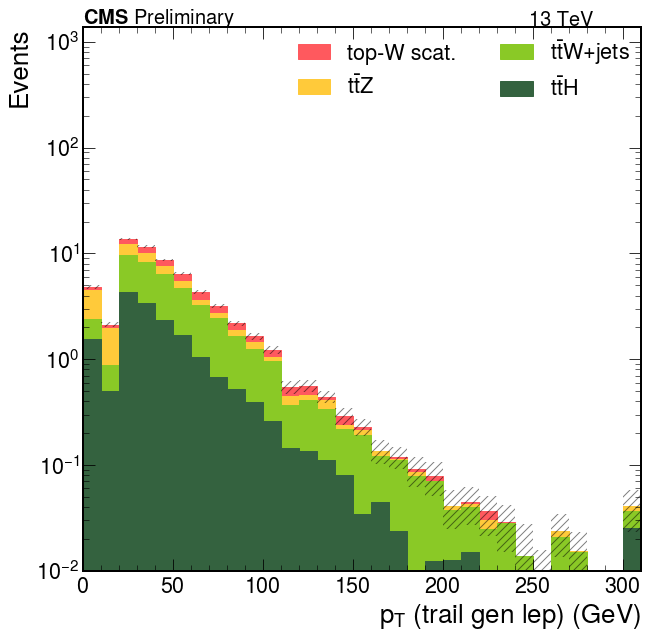

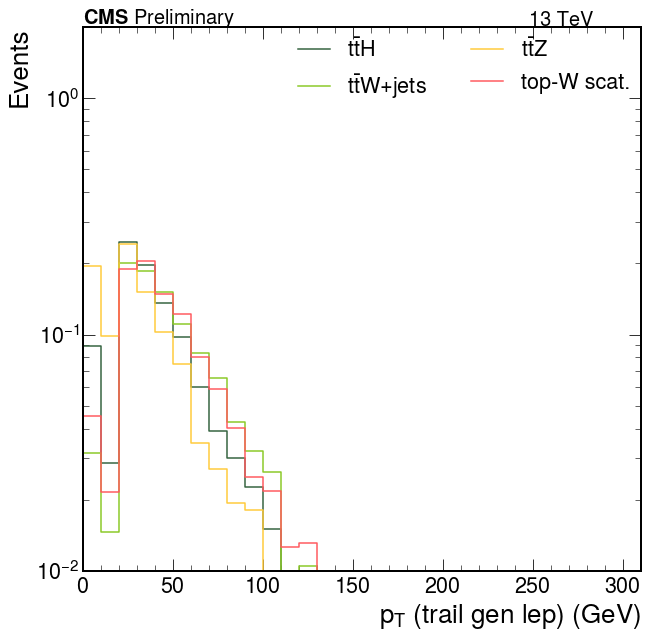

In [69]:
makePlot(output, 'trail_gen_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'trail_gen_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 46.97
Data: 0 MC: 46.97


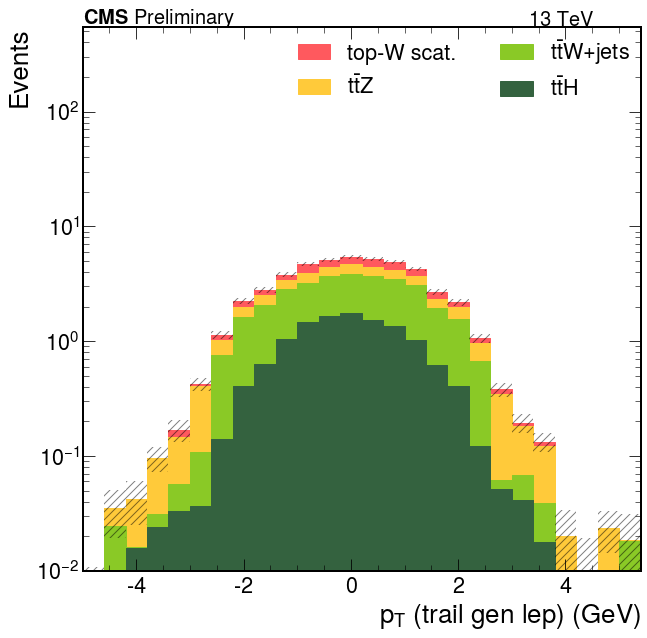

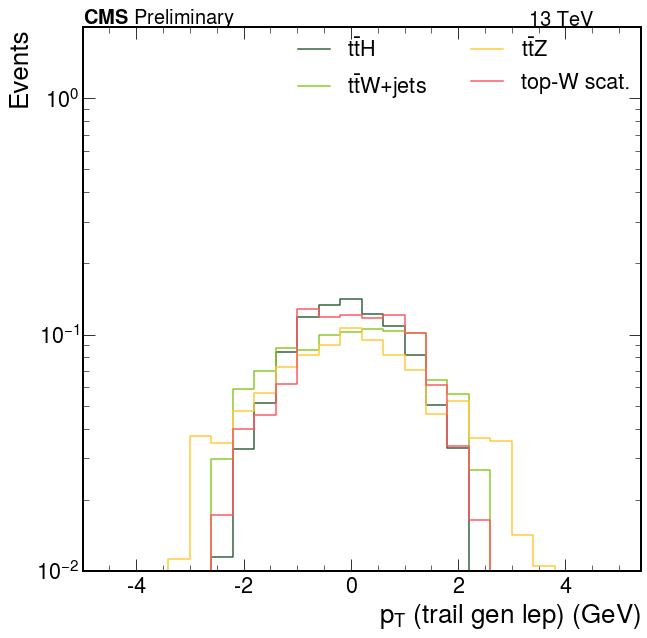

In [85]:
makePlot(output, 'trail_gen_lep', 'eta',
         data_sel=None,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'trail_gen_lep', 'eta',
         data_sel=None,
         shape=True,
         bins=eta_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail gen lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


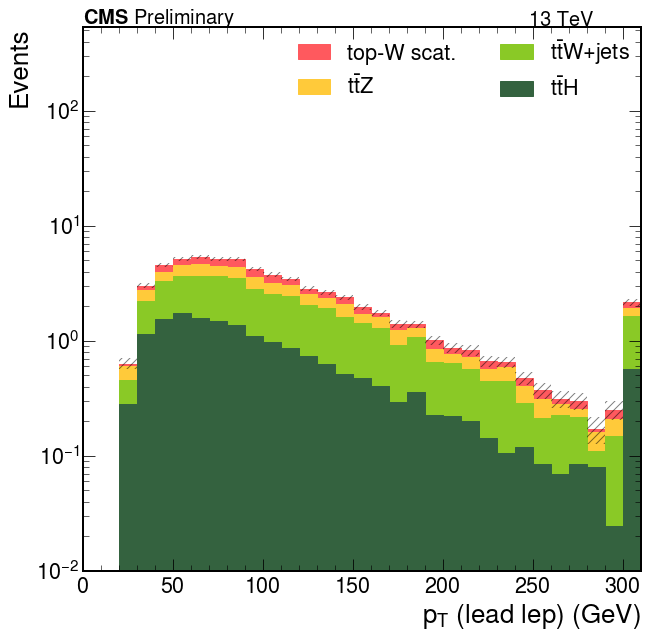

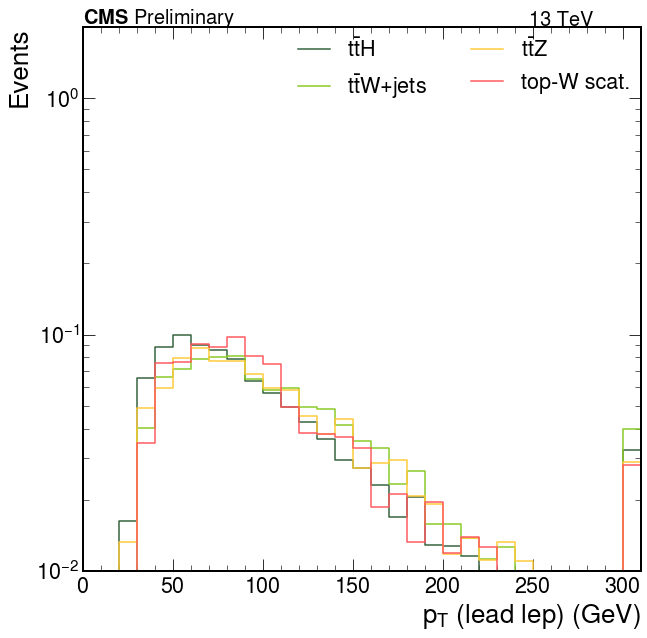

In [72]:
makePlot(output, 'lead_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'lead_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (lead lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

Data: 0 MC: 62.79
Data: 0 MC: 62.79


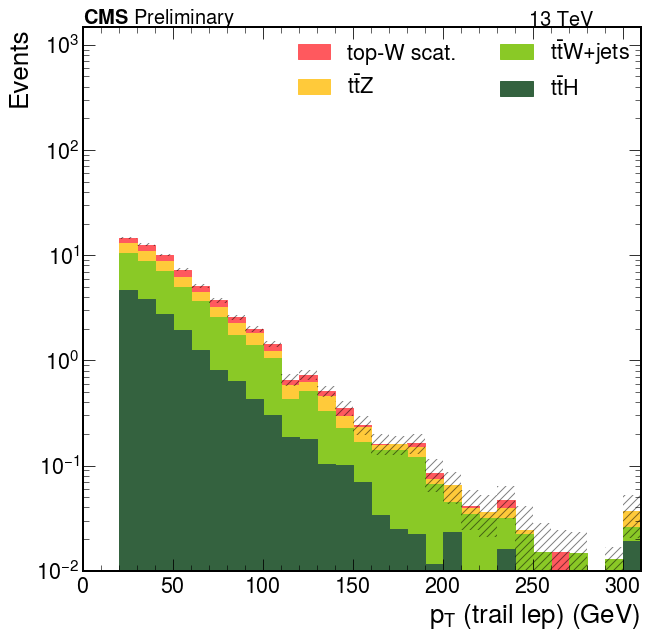

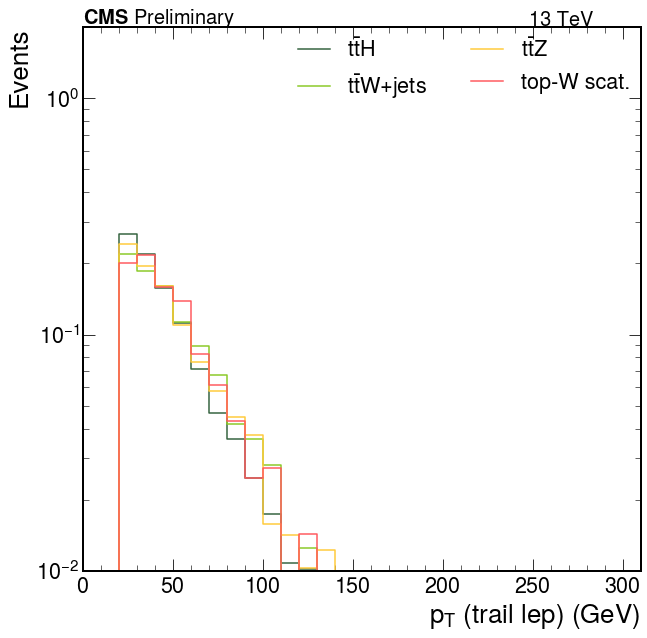

In [71]:
makePlot(output, 'trail_lep', 'pt',
         data_sel=None,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )
makePlot(output, 'trail_lep', 'pt',
         data_sel=None,
         shape=True,
         bins=pt_bins, log=True, normalize=False, axis_label=r'$p_{T}$ (trail lep) (GeV)',
         #upHists=['pt_jesTotalUp'], downHists=['pt_jesTotalDown']
        )

In [18]:
import uproot
fin = uproot.open('/home/users/dspitzba/TTW/CMSSW_10_2_9/src/inclusive_1000.root')

In [19]:
tree = fin["Events"]

In [20]:
tree.Array("genWeight")

AttributeError: 'Model_TTree_v20' object has no attribute 'Array'

In [12]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

# the below command will change to .from_root in coffea v0.7.0
events_incl = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/nanoAOD_1.root', schemaclass=NanoAODSchema).events()

from Tools.objects import *

sum_weight = sum(events_incl.genWeight)
sum_weight

47.448091104626656

In [34]:
sum(events_incl[((ak.num(muon)+ak.num(electron))==2)].genWeight)/sum_weight

0.036093418259023353

In [50]:
events_plus = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWplusJetsToLNuEWK_5f_NLO_v2_RunIIAutumn18_NANO_v4/nanoAOD_1.root', schemaclass=NanoAODSchema).events()

sum_weight = sum(events_plus.genWeight)
sum_weight

7.205300881527364

In [10]:
from Tools.basic_objects import *

In [15]:
jet = getJets(events_incl)
fwd = getFwdJet(jet)

In [22]:
lead_fwd = ak.pad_none(fwd, 1, clip=True)
ak.flatten(lead_fwd)

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='1000 * ?jet'>

In [26]:
ak.flatten(ak.pad_none(jet, 1, clip=True))

<JetArray [Jet, Jet, Jet, Jet, ... Jet, Jet, Jet] type='1000 * ?jet'>

In [30]:
ak.pad_none(jet, 1, clip=True)[(ak.num(fwd)==0)]

<JetArray [[Jet], [Jet], ... [Jet], [Jet]] type='230 * 1 * ?jet'>

In [23]:
ak.flatten(lead_fwd) + ak.flatten((ak.num(fwd)==0)*ak.pad_none(jet, 1, clip=True))

ValueError: cannot broadcast: <class 'awkward._ext.NumpyArray'>, <class 'awkward._ext.RecordArray'>

(https://github.com/scikit-hep/awkward-1.0/blob/1.0.2/src/awkward/_util.py#L906)

In [3]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

# the below command will change to .from_root in coffea v0.7.0
events_incl = NanoEventsFactory.from_root('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/nanoAOD_1.root', schemaclass=NanoAODSchema)

In [8]:
ev = events_incl.events()

In [21]:
ev.sumw

AttributeError: no field named 'sumw'

(https://github.com/scikit-hep/awkward-1.0/blob/1.0.2/src/awkward/highlevel.py#L1125)

In [14]:
import uproot
tree = uproot.open('/hadoop/cms/store/user/dspitzba/ProjectMetis/TTWJetsToLNuEWK_5f_NLO_RunIIAutumn18_NANO_v2/nanoAOD_1.root')

In [18]:
tree['Runs']

<TTree 'Runs' (8 branches) at 0x7f0edd14b970>